# Sommaire :
**Partie 0 : Mise en place de environnement**
 - <a href="#C1">Importation des librairies</a>
 - <a href="#C2">Définition des fonctions</a>
 - <a href="#C3">Importation du jeu de données</a>
 
**Partie 1 : Analyse des données**
 - <a href="#C4">Apercu et nettoyage initial des fichiers</a>
 - <a href="#C5">Création d'un dataset simple</a>
 - <a href="#C6">Création d'un dataset à partir du Kernel</a>

**Partie 2 : Modélisation**
 - <a href="#C7">Baseline</a>
 - <a href="#C8">Pré-traitement et modélisation</a>
 - <a href="#C9">Optimisation du modèle</a>
 - <a href="#C10">Optmisation des gains</a>
 - <a href="#C11">Interprétabilité du modèle </a>
 
**Partie 3 : Dashboard**
 - <a href="#C12">Deploiment du modèle</a>

# Partie 0 : Mise en place de l'environnement

# <a name="C1">Importation des librairies</a>

In [773]:
#import des librairies
import pandas as pd
from pandas import DataFrame
import numpy as np
import missingno as msno

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [774]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import warnings
warnings.filterwarnings('ignore')

In [775]:
#import des librairies
import pandas as pd
from pandas import DataFrame
import numpy as np
import missingno as msno

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn as skl

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score, make_scorer
from matplotlib.collections import LineCollection
import missingno as msno
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import math
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

In [776]:
#conda install numpy==1.20.3

In [777]:
import shap

In [778]:
#!pip install lightgbm

In [779]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import re

In [780]:
import imblearn #https://github.com/scikit-learn-contrib/imbalanced-learn
from imblearn.under_sampling  import RandomUnderSampler 
#from imblearn.under_sampling  import RandomOverSampler 

In [781]:
#versions des librairies utilisées
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


# <a name="C2">Définition des fonctions</a>

In [782]:
sampler_list = [RandomUnderSampler(random_state=14), SMOTE(random_state=14)] 
    
scaler_list = [MinMaxScaler(feature_range=(0, 1)), StandardScaler(), RobustScaler()]                                         

In [783]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [784]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [785]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('Data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('Data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [786]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('Data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('Data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [787]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('Data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [788]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('Data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [789]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('Data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [790]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('Data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [791]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [792]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [793]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
    return df

In [794]:
def undersampling_manuel(X_train, y_train):
    targ1 = y_train[y_train==1].index
    targ0 = y_train[y_train==0].sample(len(targ1)).index
    
    samp_ind = list(set(list(targ0)+list(targ1)))
    
    X_tr_undersamp = X_train.loc[samp_ind]
    y_tr_undersamp = y_train.loc[samp_ind]
    
    return X_tr_undersamp, y_tr_undersamp

In [795]:
from imblearn.pipeline import Pipeline
def modelisation_with_sampler(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un dataset donné, le résultat des différents pré-traitements sur les 5 estimateurs avec param par défaut'''                                 
                                               
    param_grid = {
        'sampler' : sampler_list,
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('sampler', RandomUnderSampler(random_state=14)),
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [796]:
from imblearn.pipeline import Pipeline
def modelisation_no_sampler(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un dataset donné, le résultat des différents pré-traitements sur les 5 estimateurs avec param par défaut'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [797]:
def modelisation_baseline(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un dataset donné, le résultat des différents pré-traitements sur les 5 estimateurs avec param par défaut'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', StandardScaler()), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

algos = {
        'LGBM' : {
            'model': LGBMClassifier(),
            'params': {
                n_estimators : np.arange(2000, 20000, 2000),
                learning_rate : [2, 0.2, 0.02, 0.002] 
                }
        },
            
        'LGBM_balanced' : {
            'model': LGBMClassifier(),
            'params': {
                n_estimators : np.arange(2000, 20000, 2000),
                learning_rate : [2, 0.2, 0.02, 0.002],
                class_weight : 'balanced'
                }
        }
}

In [798]:
def best_pretraitement(X_train, y_train):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('sampler', RandomUnderSampler(random_state=14)),
        ('scaler', RobustScaler())
    ])
    
    grid = GridSearchCV(pipeline, {}, cv=5, n_jobs=-1, verbose=3)
 
    return grid.fit(X_train, y_train)

In [799]:
from imblearn.pipeline import Pipeline
def optimisation_modele(X_train, y_train, estimator):
    '''Fonction de pré-traitement qui retourne pour un dataset donné, le résultat des différents pré-traitements sur les 5 estimateurs avec param par défaut'''                                 
                                               
    param_grid = {
        'n_estimators' : np.arange(1000, 10000, 1000),
        'learning_rate' : [1, 0.1, 0.01] 
        }
        
    grid = GridSearchCV(estimator, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc", return_train_score = True)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [800]:
def optimisation(X_train, y_train, algos):
     #'''Fonction d'optimisation des modèles qui retourne pour un pré-traitement des données spécifiques et un ensemble d'estimateurs à tester, le meilleur modèle et ses paramètres associés'''
        
    scores = []
    scores = pd.DataFrame(scores, columns=['estimator','best_score','best_params','mean_score','std_score','mean_fit_time','MAE','MSE','RMSE','R2'])
    
    for algo_name, config in algos.items():
        #Recherche d'hyperparamètres par validation croisée sur un ensemble d'estimateurs et paramètres associés
        grid = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1, verbose=3, scoring="roc_auc", return_train_score = True)
        
        #Optimisation de l'estimateur sur le jeu d'entrainement
        grid.fit(X_train, y_train)
        
        y_proba_train = grid.predict_proba(X_train)
        y_proba_test = grid.predict_proba(X_test)
              
        #Afficher les hyperparamètres optimaux et les performances correspondantes
        scores = scores.append({
            'estimator': config['model'],
            'best_score': grid.best_score_, #meilleure score
            'best_params': grid.best_params_, #meilleurs params
            'mean_score': grid.cv_results_['mean_test_score'].mean(), #score moyen
            'std_score': grid.cv_results_['std_test_score'].mean(), #ecart type
            'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), #temps d'execution
            'auc' : round(roc_auc_score(y_test, y_proba_test[:,1]),3)
        },  ignore_index=True)
        
    return scores

In [801]:
def evaluation(estimator, X_train, y_train, X_test, y_test):
    
    estimator.fit(X_train, y_train)
    
    # Afficher la performance du résultat sur le jeu de test
    y_test_pred = estimator.predict(X_test)
    y_test_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    mat = confusion_matrix(y_test, y_test_pred)
    
    print('Confusion Matrix:\n', mat)
    
    labels = ['Cat: 0', 'Cat: 1']
    
    sns.heatmap(mat, 
                square=True,
                annot=True,
                fmt='d',
                cbar=False,
                xticklabels=labels,
                yticklabels=labels,
               )
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()   
    
    pd.crosstab(y_test_pred, y_test, rownames=['Predicted'], colnames=['Actual'])
    
    print("Accuracy = " , accuracy_score(y_test, y_test_pred))
    print("Precision = " ,precision_score(y_test, y_test_pred))
    print("Recall = " ,recall_score(y_test, y_test_pred))
    print("F0.5 Score = " ,fbeta_score(y_test, y_test_pred, average='weighted', beta=0.5))
    
    fpr, tpr, thresholds = roc_curve(y_test,  y_test_pred_proba)
    #auc = roc_auc_score(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.plot(fpr,tpr,label="AUC ="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [802]:
def matrix_roc_auc(y_true, y_pred, y_pred_proba, size):

    fig = plt.figure(figsize=size)
  
    #plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="")
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)


    #plt.subplot(222)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='darkgreen', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
 
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    return tn, fp, fn, tp

In [803]:
def score_banque(TN, FP, FN, TP, coeff_TN, coeff_FP, coeff_FN, coeff_TP):

    total = (coeff_TN*TN + coeff_FP*FP + coeff_FN*FN + coeff_TP*TP)

    #calcul du gain maximal - aucune perte d'argent. 
    max_gain = (TN + FP)*coeff_TN + (TP + FN)*coeff_TP

    #calcul du gain minimal (perte)- aucun gain d'argent. 
    min_gain = (TN + FP)*coeff_FP + (TP + FN)*coeff_FN

    #normalisation min-max feature scalling : 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

# <a name="C3">Importation du jeu de données</a>

In [804]:
#import des 10 fichiers constituant le jeu de données
df_test = pd.read_csv('Data/application_test.csv')
df_train = pd.read_csv('Data/application_train.csv')
#bureau = pd.read_csv('bureau.csv')
#bureau_balance = pd.read_csv('bureau_balance.csv')
#previous_app = pd.read_csv('previous_application.csv')
#homecredit_desc = pd.read_csv('HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
#sampl_submission = pd.read_csv('sample_submission.csv')
#cash_balance = pd.read_csv('POS_CASH_balance.csv')
#cc_balance = pd.read_csv('credit_card_balance.csv')
#inst_payments = pd.read_csv('installments_payments.csv')

In [805]:
#Création de listes
df_liste = [df_test, df_train, bureau, bureau_balance, previous_app, homecredit_desc, sampl_submission, cash_balance, cc_balance, inst_payments]
df_noms = ['df_test', 'df_train', 'bureau', 'bureau_balance', 'previous_app', 'homecredit_desc', 'sampl_submission', 'cash_balance', 'cc_balance', 'inst_payments']

# Partie 1 : Analyse des données

# <a name="C4">Apercu et nettoyage initial des fichiers</a>

In [806]:
#Affichage des 2 premieres lignes pour s'assurer de l'import.
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.head(2))
    print('\n')

df_test :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.066,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0




df_train :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0




bureau :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN




bureau_balance :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C




previous_app :


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0




homecredit_desc :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN




sampl_submission :


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5




cash_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0




cc_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.00,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.08,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0




inst_payments :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [807]:
#Affichage de la taille de chaque fichier
for df, nom in zip(df_liste, df_noms):
    print(nom, ':', df.shape)

df_test : (48744, 121)
df_train : (307511, 122)
bureau : (1716428, 17)
bureau_balance : (27299925, 3)
previous_app : (1670214, 37)
homecredit_desc : (219, 5)
sampl_submission : (48744, 2)
cash_balance : (10001358, 8)
cc_balance : (3840312, 23)
inst_payments : (13605401, 8)


In [808]:
#Aperçu des colonnes
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.info())

df_test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


None

df_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

bureau :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


None

bureau_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


None

previous_app :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT          

None

homecredit_desc :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


None

sampl_submission :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


None

cash_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


None

cc_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INST

None

inst_payments :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


None

In [809]:
#Recherche des doublons
for df, nom in zip(df_liste, df_noms):
    print(nom, df.duplicated().sum())

df_test 0
df_train 0
bureau 0
bureau_balance 0
previous_app 0
homecredit_desc 0
sampl_submission 0
cash_balance 0
cc_balance 0
inst_payments 0


In [810]:
#Aperçu des données manquantes pour chaque fichier (% de NaN)
for df, nom in zip(df_liste, df_noms):
    print(nom, df.isna().mean().mean())

df_test 0.23811686761532344
df_train 0.24395941907129431
bureau 0.13502552290879322
bureau_balance 0.0
previous_app 0.17976877473444977
homecredit_desc 0.12146118721461188
sampl_submission 0.0
cash_balance 0.0006518864738168557
cc_balance 0.0665407439268748
inst_payments 5.337953655316738e-05


# <a name="C5">Création d'un dataset simple</a>

In [811]:
#Affichage des 2 premieres lignes pour s'assurer de l'import.
df_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [812]:
#Taille du fichier data
df_train.shape

(307511, 122)

In [813]:
#Aperçu des colonnes
print(list(df_train.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [814]:
#Nombre de variables par type
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [815]:
#Retrait des colonnes catégorielles
df_train.drop(df_train.select_dtypes('object').columns,1,inplace=True)

In [816]:
#Aperçu valeurs manquantes
df_train.isna().mean()

SK_ID_CURR                    0.000000
TARGET                        0.000000
CNT_CHILDREN                  0.000000
AMT_INCOME_TOTAL              0.000000
AMT_CREDIT                    0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 106, dtype: float64

<AxesSubplot:>

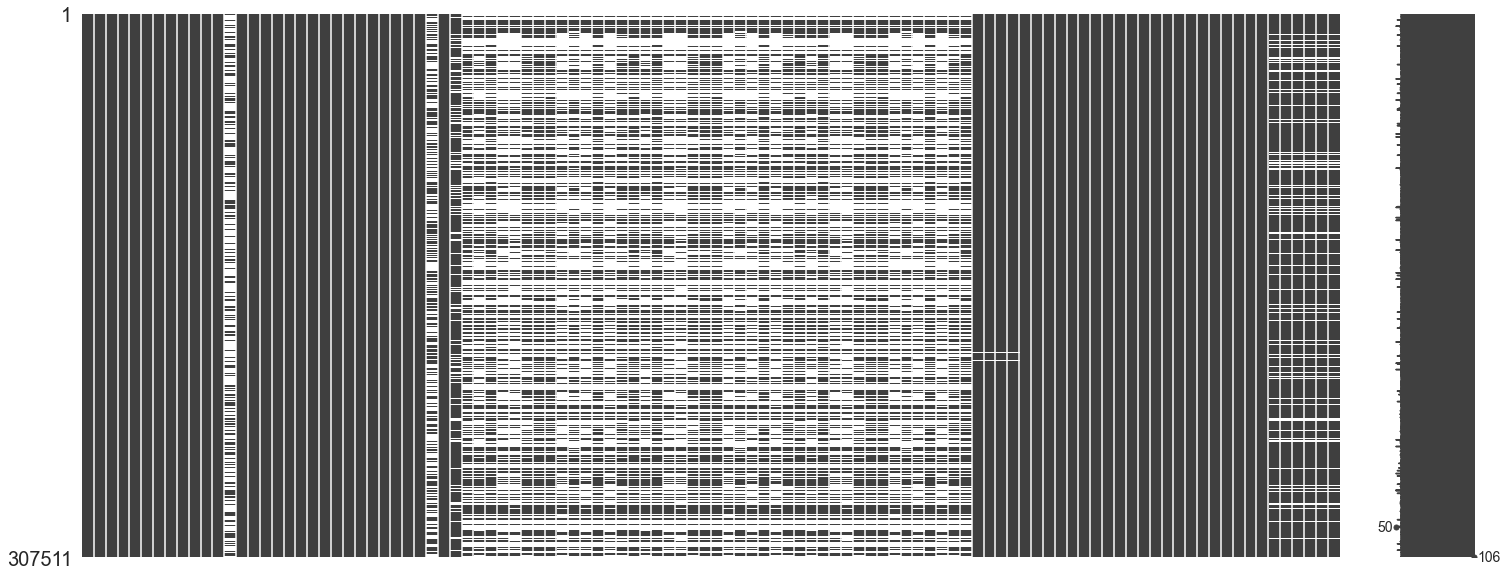

In [817]:
#Aperçu des données manquantes pour le fichier app (% de NaN)
msno.matrix(df_train)

In [818]:
#Suppression des variables ayant plus de 50% de NaN
df_train = df_train[df_train.columns[df_train.isna().sum()/df_train.shape[0]<0.1]]
df_train.shape

(307511, 54)

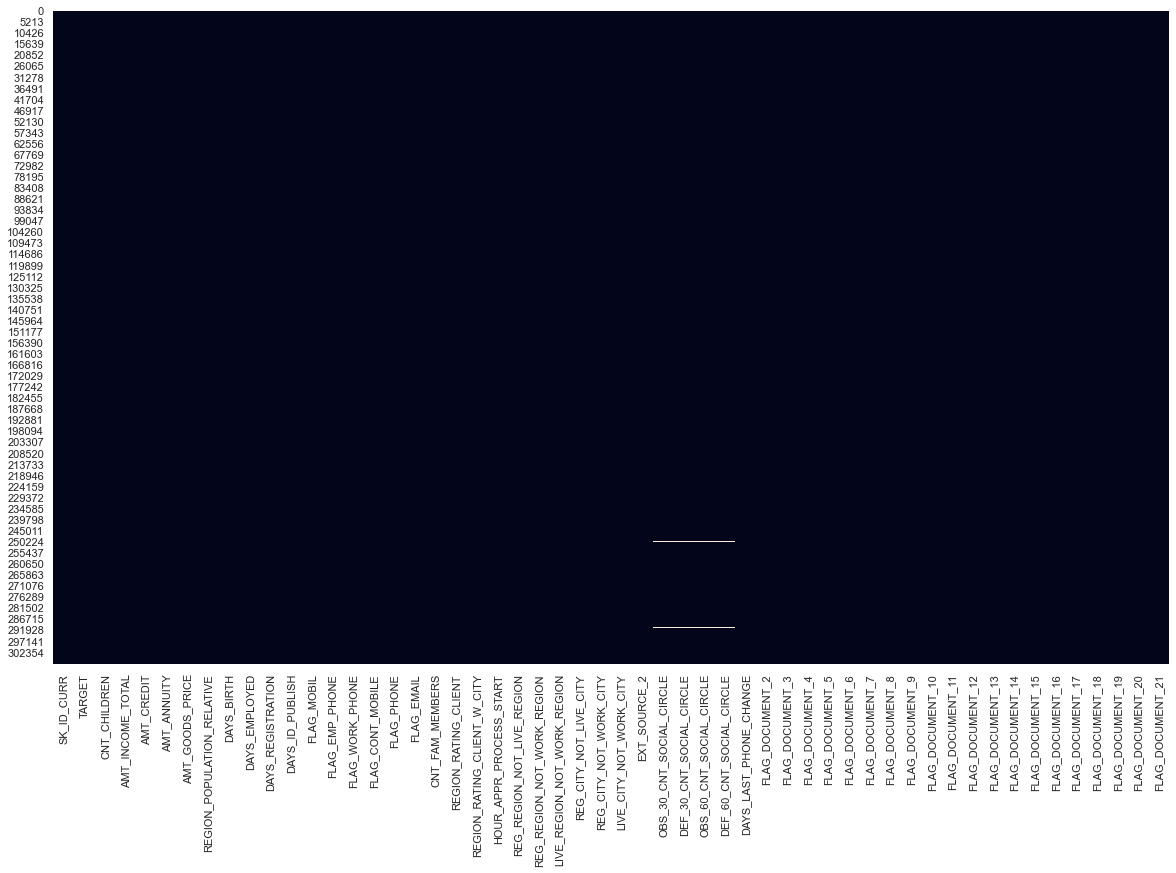

In [819]:
#Visualisation des données manquantes
plt.figure(figsize=(20,12))
sns.heatmap(df_train.isna(), cbar= False)
plt.show()

In [820]:
#Affichage des stats sur les variables
pd.pandas.set_option('display.max_columns', None)
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.068510e+05,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,5.143927e-01,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,1.910602e-01,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924574e-01,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-325

In [821]:
#Analyse et visualisation de la Target et des variables avec outliers ou dont les valeurs sont innatendues
COL_TARGET = ['TARGET']
COL_FEATURES_AB = ['AMT_INCOME_TOTAL','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
COL = COL_TARGET + COL_FEATURES_AB
COL

['TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

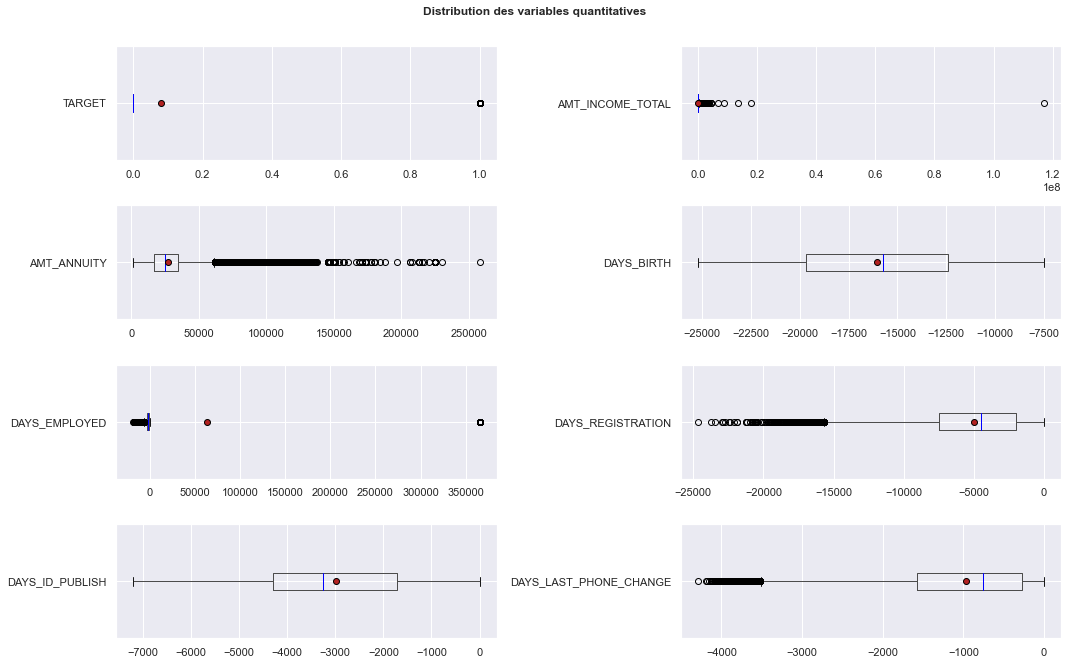

In [822]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [823]:
#Identification des outliers AMT_INCOME
df_train[df_train.AMT_INCOME_TOTAL>1e8]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
12840,114967,1,1,117000000.0,562491.0,26194.5,454500.0,0.010643,-12615,-922,-6762.0,-3643,1,1,0,1,0,0,3.0,2,2,14,0,0,0,0,0,0,0.113161,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [824]:
#Suppression de cette outliers compte tenu de leur faible nombre
df_train = df_train[df_train.AMT_INCOME_TOTAL<1e8]

In [825]:
#Identification des outliers DAYS_EMPLOYED
OUT = df_train[df_train['DAYS_EMPLOYED'] > 300000]
OUT['DAYS_EMPLOYED']

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

In [826]:
#Mise à jour de l'outlier en NaN compte tenu du nombre d'occurences
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243,np.nan)

In [827]:
#Changement de DAYS_BIRTH de jours à années
df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH'] / -365
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / -365
df_train['DAYS_REGISTRATION'] = df_train['DAYS_REGISTRATION'] / -365
df_train['DAYS_ID_PUBLISH'] = df_train['DAYS_ID_PUBLISH'] / -365
df_train['DAYS_LAST_PHONE_CHANGE'] = df_train['DAYS_LAST_PHONE_CHANGE'] / -365
df_train['AMT_ANNUITY'] = df_train['AMT_ANNUITY'] 

In [828]:
#Taille du jeu
df_train.shape

(307510, 54)

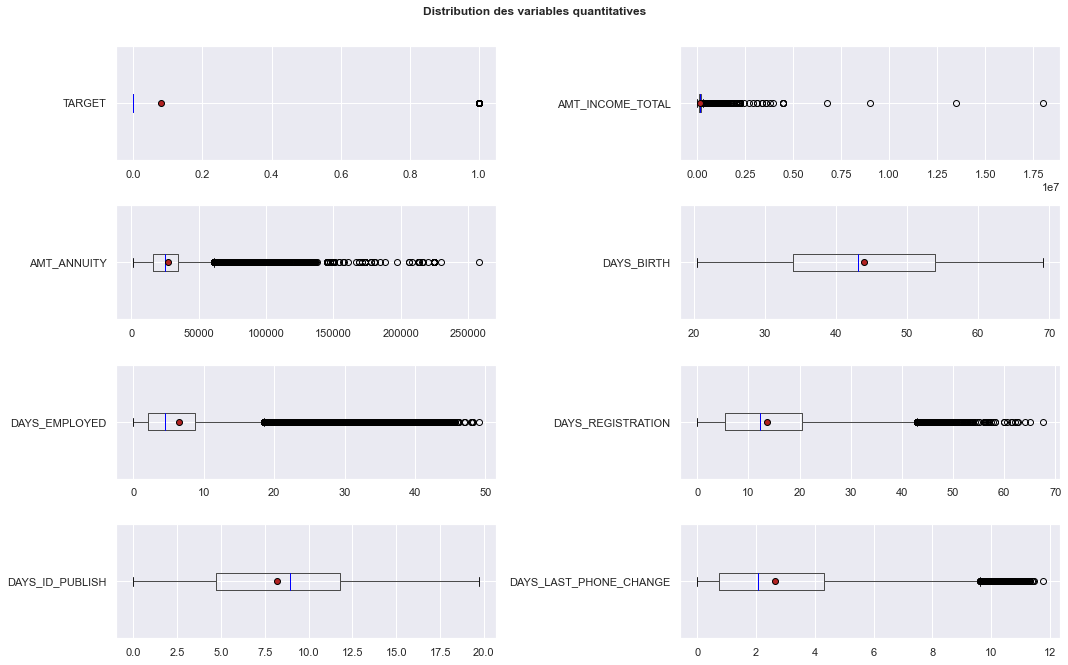

In [829]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

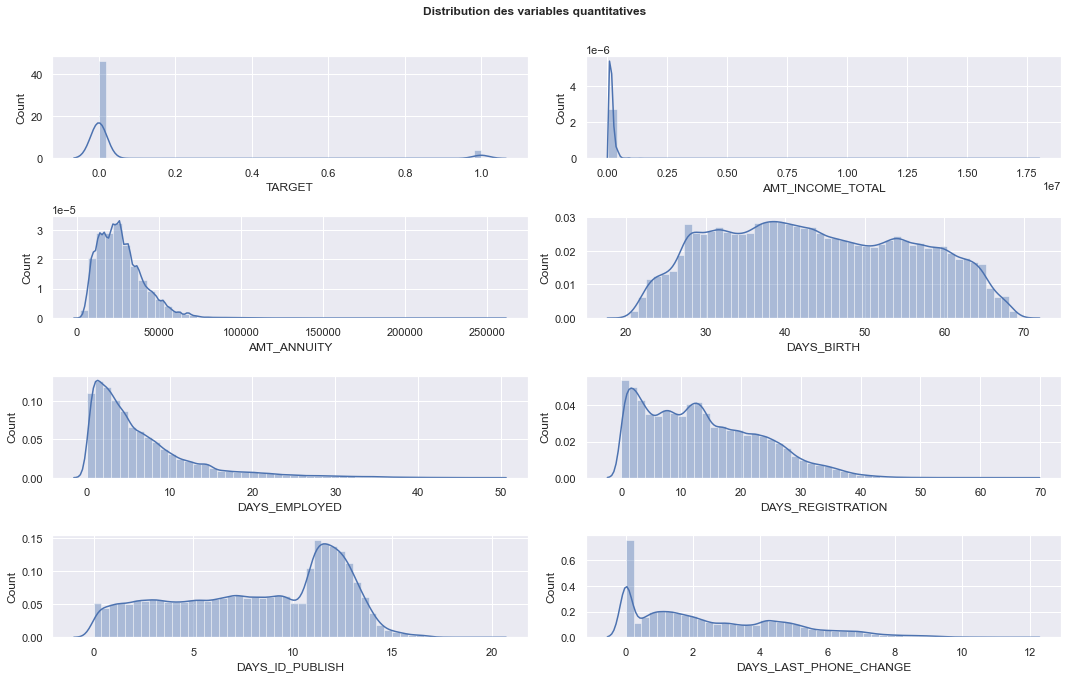

In [830]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    sns.distplot(df_train[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [831]:
df_train.shape

(307510, 54)

In [832]:
#Suppression des lignes avec un NaN
df_train = df_train.dropna()
df_train.shape

(250518, 54)

In [833]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FL

In [834]:
df_train['NB_DOCUMENTS']=(df_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)
df_train.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],1, inplace=True)

In [835]:
#Either remove or create new feature not to loose info
 # Sum of contact flag vars
df_train['NB_CONTACTS']=((df_train[['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'
                           ]]).sum(axis=1))
df_train.drop(['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'],1, inplace=True)

In [836]:
# Mean *_CNT_SOCIAL_CIRCLE
df_train['MEAN_DEFAULT_OBS']=((df_train[['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'
                                 ]]).mean(axis=1))//4
df_train.drop(['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'],1, inplace=True)

In [837]:
# Sum of adress like vars
df_train['NB_ADDRESS_MISSMATCH']=((df_train[['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY']]).sum(axis=1))
df_train.drop(['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY'],1, inplace=True)

<Figure size 1080x864 with 0 Axes>

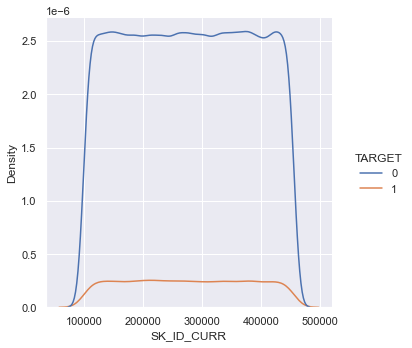

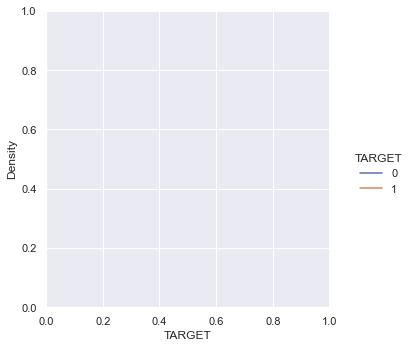

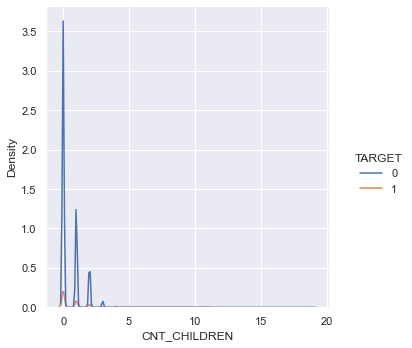

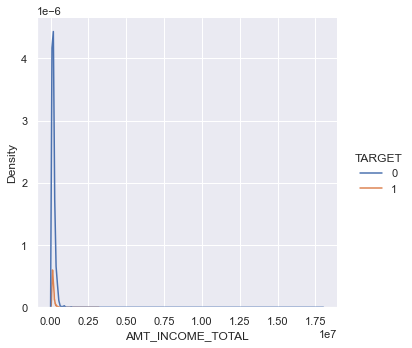

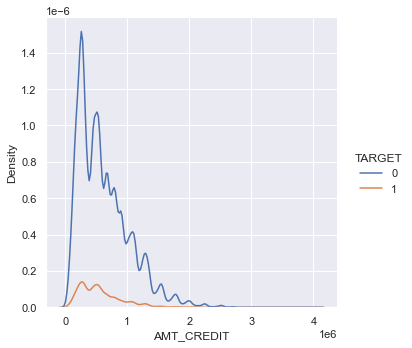

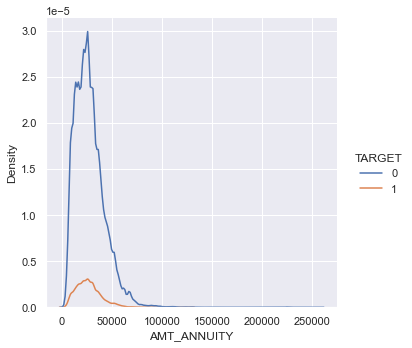

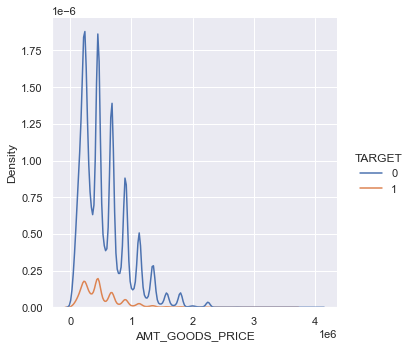

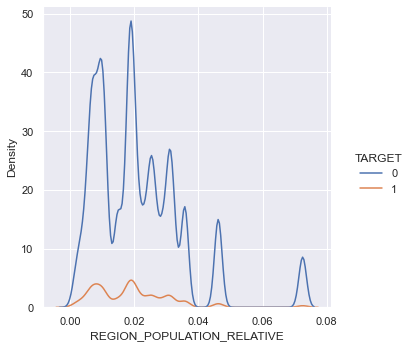

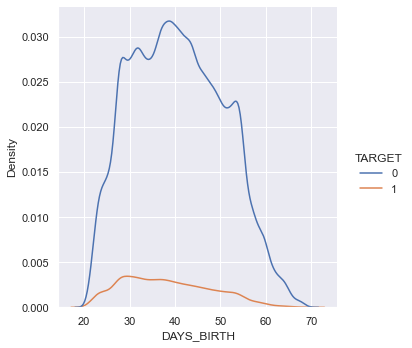

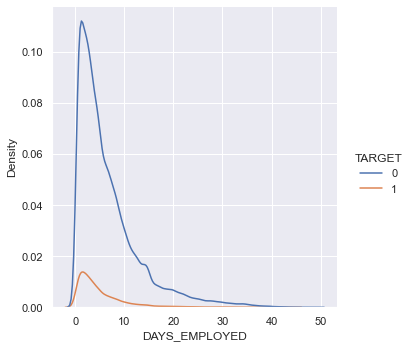

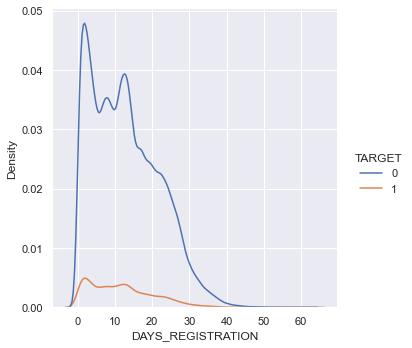

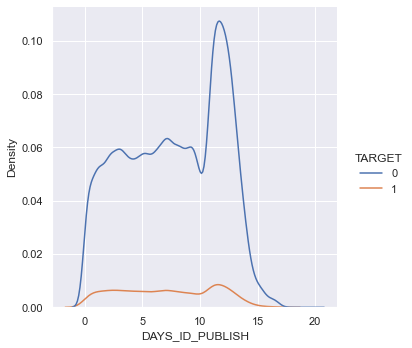

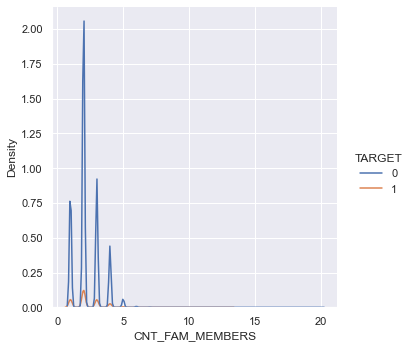

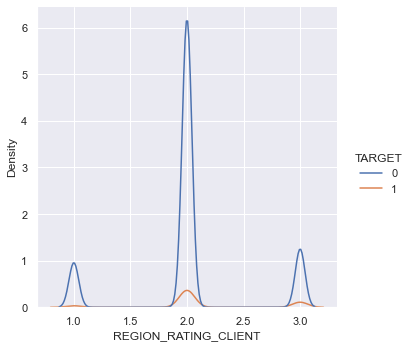

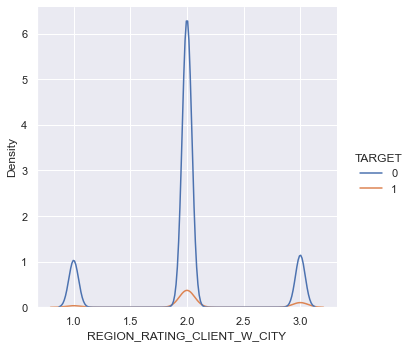

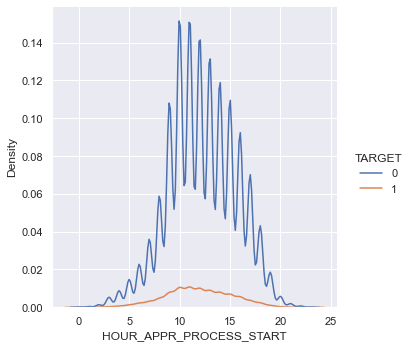

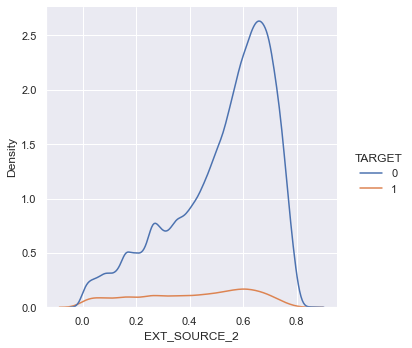

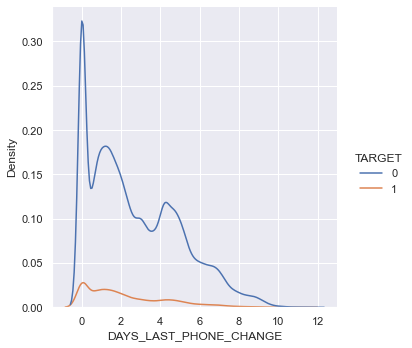

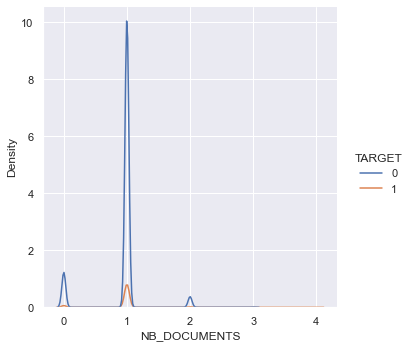

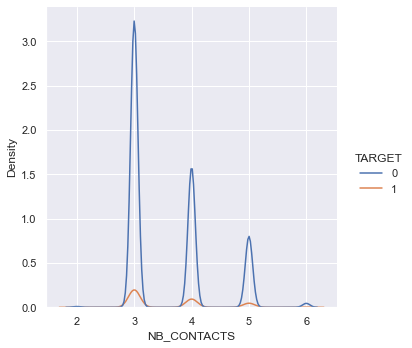

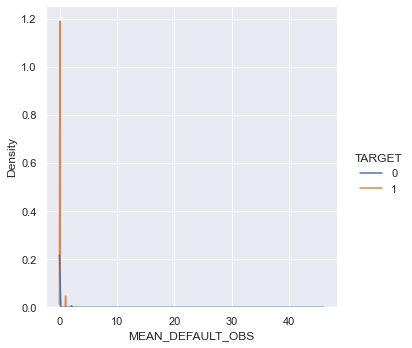

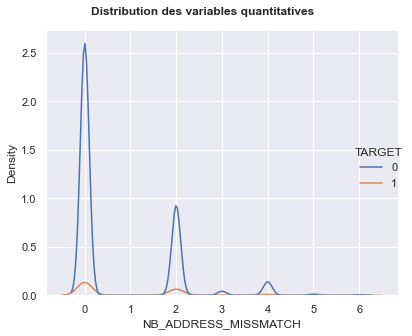

In [838]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

COL = df_train.columns

for i, col in enumerate(COL,1):
    #ax = fig.add_subplot(6,3,i)
    sns.displot(data=df_train, x=col, hue="TARGET", kind="kde")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

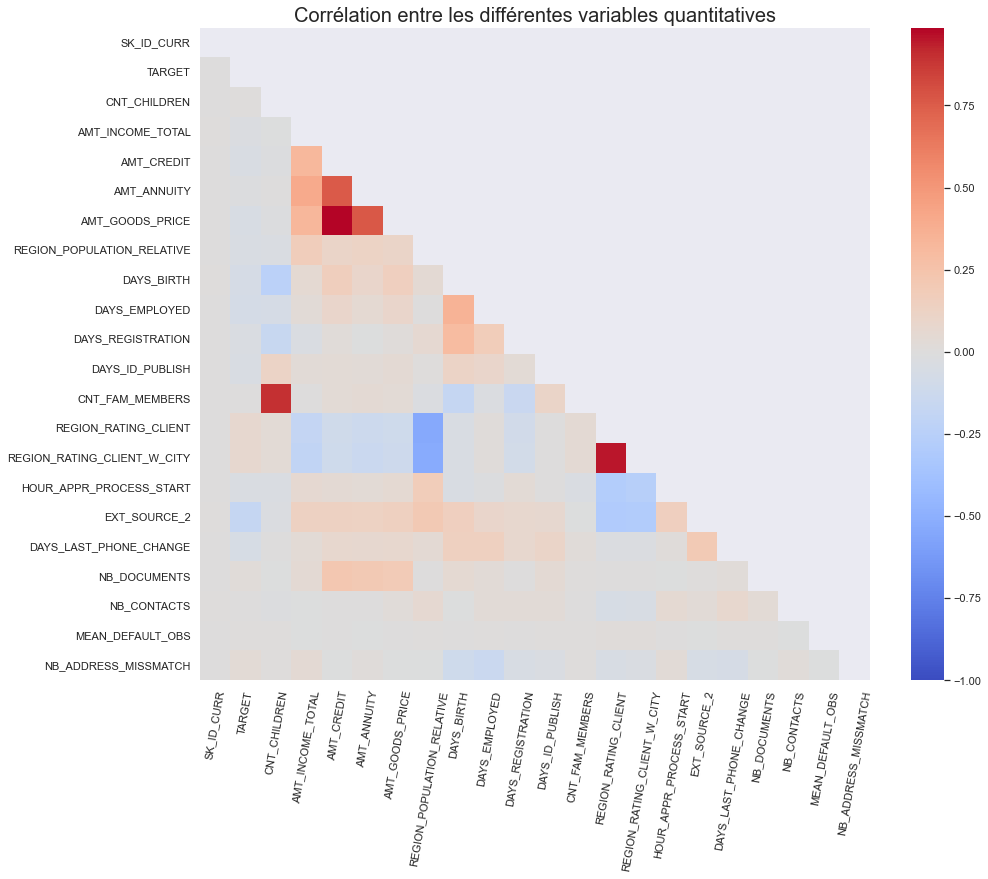

In [839]:
#Heatmap correlation entre variables quantitatives
plt.figure(figsize=(15,12))
#sns.set(font_scale=1.5)
plt.title('Corrélation entre les différentes variables quantitatives', fontsize = 20)

corr = df_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = False)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

In [840]:
df_train[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].describe()

,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
count,250518.000000,250518.000000
mean,2.045258,2.023918
std,0.512262,0.506336
min,1.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,3.000000,3.000000


In [841]:
df_train.drop(['REGION_RATING_CLIENT_W_CITY'],1, inplace=True)

In [842]:
df_train[['CNT_FAM_MEMBERS','CNT_CHILDREN']].describe()

,CNT_FAM_MEMBERS,CNT_CHILDREN
count,250518.000000,250518.000000
mean,2.252868,0.498563
std,0.942067,0.763292
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,20.000000,19.000000


In [843]:
df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / (df_train['CNT_FAM_MEMBERS'])

In [844]:
df_train.drop(['CNT_FAM_MEMBERS','AMT_INCOME_TOTAL'],1, inplace=True)

In [845]:
df_train['CREDIT_PER_GOOD']=df_train['AMT_CREDIT']/df_train['AMT_GOODS_PRICE']

In [846]:
df_train['ANNUITY_PER_GOOD']=df_train['AMT_ANNUITY']/df_train['AMT_GOODS_PRICE']

In [847]:
df_train.drop(['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_CHILDREN'],1, inplace=True)

In [848]:
df_train['YRS_WORKING_PER_BIRTH']=df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [849]:
df_train.drop(['DAYS_EMPLOYED','DAYS_BIRTH'],1, inplace=True)

In [850]:
df_train.shape

(250518, 17)

In [851]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'REGION_POPULATION_RELATIVE',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE',
       'NB_DOCUMENTS', 'NB_CONTACTS', 'MEAN_DEFAULT_OBS',
       'NB_ADDRESS_MISSMATCH', 'INCOME_PER_PERSON', 'CREDIT_PER_GOOD',
       'ANNUITY_PER_GOOD', 'YRS_WORKING_PER_BIRTH'],
      dtype='object')

In [852]:
df_train_vif = df_train.copy()

In [853]:
X = df_train_vif.drop(['SK_ID_CURR','TARGET'], axis=1)

vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
12,49.560987,CREDIT_PER_GOOD
8,20.205251,NB_CONTACTS
3,18.975556,REGION_RATING_CLIENT
4,14.197000,HOUR_APPR_PROCESS_START
5,9.177337,EXT_SOURCE_2
7,8.371645,NB_DOCUMENTS
13,6.917681,ANNUITY_PER_GOOD
2,4.469107,DAYS_ID_PUBLISH
0,4.286112,REGION_POPULATION_RELATIVE
1,3.100660,DAYS_REGISTRATION


In [854]:
df_train_vif.drop(['CREDIT_PER_GOOD','NB_CONTACTS','REGION_RATING_CLIENT','HOUR_APPR_PROCESS_START','EXT_SOURCE_2','NB_DOCUMENTS','ANNUITY_PER_GOOD'],1, inplace=True)

In [855]:
df_train_vif.shape

(250518, 10)

Variance inflation factor is a measure of the amount of multicollinearity in a set of multiple regression variables.

Variance inflation factor measures how much the behavior (variance) of an independent variable is influenced, or inflated, by its interaction/correlation with the other independent variables

VIF = 1: Not correlated
VIF =1-5: Moderately correlated
VIF >5: Highly correlated


In [856]:
#Remove variables with VIF above 5
X = df_train_vif.drop(['SK_ID_CURR','TARGET'], axis=1)
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,3.398716,DAYS_ID_PUBLISH
0,2.912321,REGION_POPULATION_RELATIVE
1,2.746555,DAYS_REGISTRATION
6,2.376359,INCOME_PER_PERSON
3,2.342791,DAYS_LAST_PHONE_CHANGE
7,2.305487,YRS_WORKING_PER_BIRTH
5,1.320917,NB_ADDRESS_MISSMATCH
4,1.024290,MEAN_DEFAULT_OBS


In [857]:
df_train_vif.to_csv('df_train_simple.csv', index=False)

# <a name="C6">Creation d'un dataset basé sur le Kernel</a>

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_train_test_kernel = main()

df_train_test_kernel.shape

df_train_test_kernel.head()

df_train_test_kernel.to_csv('df_train_test_kernel.csv', index=False)

# Partie 2 : Modélisation

In [858]:
#data = df_train_vif.copy()
data = pd.read_csv('df_train_test_kernel.csv')
data_name = 'KERNEL'

In [859]:
# On se rassure que les noms des colonnes sont adéquats (sans espaces)
data.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").replace(","," ").replace("["," ").replace("]"," ").replace("{"," ").replace("}"," ").replace(":"," ").upper(), data.columns))
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [860]:
display(data.columns)

Index(['INDEX', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_SIGNED_MAX',
       'CC_NAME_CONTRACT_STATUS_SIGNED_MEAN',
       'CC_NAME_CONTRACT_STATUS_SIGNED_SUM',
       'CC_NAME_CONTRACT_STATUS_SIGNED_VAR', 'CC_NAME_CONTRACT_STATUS_NAN_MIN',
       'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN_VAR',
       'CC_COUNT'],
      dtype='object', length=798)

In [861]:
data['EXT_SOURCE_3'].head(2)

0    0.139376
1   NaN      
Name: EXT_SOURCE_3, dtype: float64

# <a name="C7">Séparation des données en train et test</a>

In [862]:
data = data.sample(frac =.1)
data.head()

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_CASH_LOANS,NAME_CONTRACT_TYPE_REVOLVING_LOANS,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_MATERNITY_LEAVE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_ACADEMIC_DEGREE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_WAITERSBARMEN_STAFF,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE

In [863]:
data.shape

(35625, 798)

In [864]:
if data_name == 'KERNEL':
    train_df = data[data['TARGET'].notnull()]
    test_df = data[data['TARGET'].isnull()]
    #feats_kernel = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','index','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']]
    #X=train_df[feats_kernel]
    y=train_df['TARGET']
    list_out = ['TARGET','SK_ID_CURR','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
    
    X = train_df.drop(columns = list_out) #on vire les colonnes infinies
else:
    feats = [f for f in data.columns if f not in ['TARGET','SK_ID_CURR']]
    X=data[feats]
    y=data['TARGET']

In [865]:
X.max().sort_values()

DAYS_BIRTH                         -7.489000e+03
DAYS_EMPLOYED                      -1.300000e+01
CLOSED_DAYS_CREDIT_MIN             -1.100000e+01
CLOSED_DAYS_CREDIT_MEAN            -1.100000e+01
INSTAL_DAYS_ENTRY_PAYMENT_MEAN     -9.000000e+00
                                        ...     
CC_AMT_DRAWINGS_CURRENT_VAR         2.700000e+11
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR    2.745975e+11
CC_AMT_PAYMENT_CURRENT_VAR          2.747122e+11
CC_AMT_DRAWINGS_ATM_CURRENT_VAR     2.960651e+11
CC_AMT_CREDIT_LIMIT_ACTUAL_VAR      4.639091e+11
Length: 793, dtype: float64

In [866]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

In [867]:
X_train.shape

(24597, 793)

In [868]:
y_train.shape

(24597,)

# <a name="C7">Baseline</a>

In [869]:
results = pd.DataFrame()

In [870]:
result = modelisation_baseline(X_train, y_train, "no_sampler", DummyClassifier(strategy="most_frequent"))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [871]:
result = modelisation_baseline(X_train, y_train, "no_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [872]:
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.917876,11.150036,0.921,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.917876,11.678541,0.921,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.917876,7.282610,0.921,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918079,17.714715,0.920,0.412,0.043,0.078,0.749
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.913973,15.848578,0.920,0.412,0.043,0.078,0.749
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.644916,12.629440,0.920,0.412,0.043,0.078,0.749


# <a name="C8">Pré-traitement et modélisation</a>

### Prétraitement avec manuel undersampling

In [873]:
X_tr_under, y_tr_under = undersampling_manuel(X_train, y_train)

In [874]:
y_tr_under.value_counts()

0.0    2020
1.0    2020
Name: TARGET, dtype: int64

In [875]:
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [876]:
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", KNeighborsClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [877]:
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LGBMClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Prétraitement avec class weight balanced

In [878]:
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LogisticRegression(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [879]:
#result = modelisation_no_sampler(X_train, y_train, "class_balanced", KNeighborsClassifier(class_weight='balanced'))
#results = results.append(result)

In [880]:
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LGBMClassifier(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Prétraitement avec SMOTE and RandomUnderSampling

In [881]:
#Application de différents pré-traitements à ce dataset sur 5 modèles (sans paramètres) pour identifier le "meilleur" pré-traitement.
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LogisticRegression())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)
#result.sort_values(by='rank_test_score', ascending=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [882]:
#Application de différents pré-traitements à ce dataset sur 5 modèles (sans paramètres) pour identifier le "meilleur" pré-traitement.
result = modelisation_with_sampler(X_train, y_train, "param_sampler", KNeighborsClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)
#result.sort_values(by='rank_test_score', ascending=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [883]:
#Application de différents pré-traitements à ce dataset sur 5 modèles (sans paramètres) pour identifier le "meilleur" pré-traitement.
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LGBMClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [884]:
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.917876,11.150036,0.921,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.917876,11.678541,0.921,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.917876,7.282610,0.921,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918079,17.714715,0.920,0.412,0.043,0.078,0.749
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.913973,15.848578,0.920,0.412,0.043,0.078,0.749
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.644916,12.629440,0.920,0.412,0.043,0.078,0.749
0,LogisticRegression(),manual_sampler,{'scaler': MinMaxScaler()},0.739665,2.110033,0.681,0.157,0.695,0.256,0.740
1,LogisticRegression(),manual_sampler,{'scaler': StandardScaler()},0.703166,2.441346,0.681,0.157,0.695,0.256,0.740
2,LogisticRegression(),manual_sampler,{'scaler': RobustScaler()},0.536786,2.051458,0.681,0.157,0.695,0.256,0.740
0,KNeighborsClassifier(),manual_sampler,{'scaler': MinMaxScaler()},0.600611,0.611400,0.566,0.095,0.532,0.162,0.576


### Résumé des modèles

In [885]:
top_results = results.sort_values(by=['auc','f1score','mean_fit_time'], ascending=[False, True, True])
top_results.head(15)

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
2,LogisticRegression(class_weight='balanced'),class_balanced,{'scaler': RobustScaler()},0.547050,12.585016,0.706,0.162,0.654,0.259,0.750
1,LogisticRegression(class_weight='balanced'),class_balanced,{'scaler': StandardScaler()},0.726139,16.566951,0.706,0.162,0.654,0.259,0.750
0,LogisticRegression(class_weight='balanced'),class_balanced,{'scaler': MinMaxScaler()},0.742149,17.792171,0.706,0.162,0.654,0.259,0.750
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.644916,12.629440,0.920,0.412,0.043,0.078,0.749
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.913973,15.848578,0.920,0.412,0.043,0.078,0.749
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918079,17.714715,0.920,0.412,0.043,0.078,0.749
2,LGBMClassifier(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': RobustScaler()}",0.742343,15.400352,0.919,0.300,0.019,0.035,0.745
0,LGBMClassifier(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': MinMaxScaler()}",0.743141,15.732332,0.919,0.300,0.019,0.035,0.745
1,LGBMClassifier(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': StandardScaler()}",0.743631,16.354534,0.919,0.300,0.019,0.035,0.745
5,LGBMClassifier(),param_sampler,"{'sampler': SMOTE(random_state=14), 'scaler': RobustScaler()}",0.747941,36.004044,0.919,0.300,0.019,0.035,0.745


# <a name="C9">Optimisation du modèle</a>

In [886]:
best_model = LGBMClassifier()

In [887]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
sampler = RandomUnderSampler(random_state=14)
scaler = MinMaxScaler()

In [888]:
X_tr_imp = imputer.fit_transform(X_train)
X_te_imp = imputer.fit_transform(X_test)

In [889]:
X_tr_sc = scaler.fit_transform(X_tr_imp)
X_te_sc = scaler.fit_transform(X_te_imp)

In [890]:
X_train = pd.DataFrame(scaler.transform(X_tr_imp), 
                      index=X_train.index, 
                      columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_te_imp), 
                     index=X_test.index, 
                     columns=X_test.columns)

In [891]:
X_tr_samp, y_tr_samp = sampler.fit_resample(X_train, y_train)

Confusion Matrix:
 [[3841 1824]
 [ 156  329]]


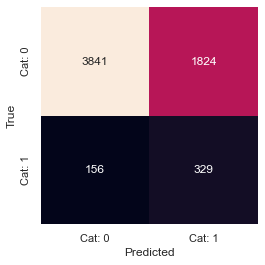

Accuracy =  0.6780487804878049
Precision =  0.15281003251277286
Recall =  0.6783505154639176
F0.5 Score =  0.8312585625849392


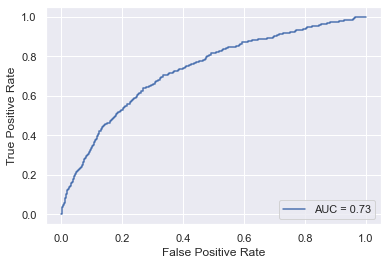

In [892]:
evaluation(best_model, X_tr_samp, y_tr_samp, X_test, y_test)

scores = optimisation_modele(X_tr_samp, y_tr_samp, best_model)

scores

In [893]:
probability = best_model.predict_proba(X_test)

In [894]:
probability_default_payment = probability[:, 1]

In [895]:
prediction = best_model.predict(X_test)

In [896]:
roc_auc = roc_auc_score(y_test, probability_default_payment)

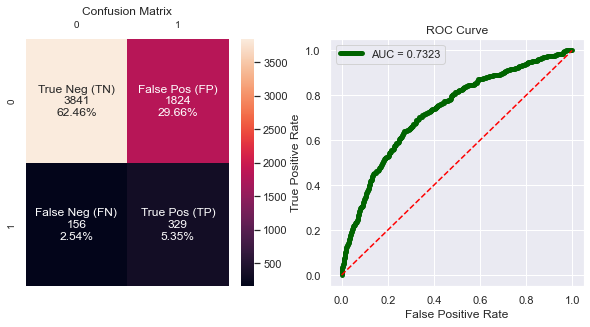

True negative =  3841
False positive =  1824
False negative =  156
True positive =  329


In [897]:
tn, fp, fn, tp = matrix_roc_auc(y_test, prediction, probability, (10,10))

# <a name="C10">Interprétabilité du modèle</a>

In [898]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

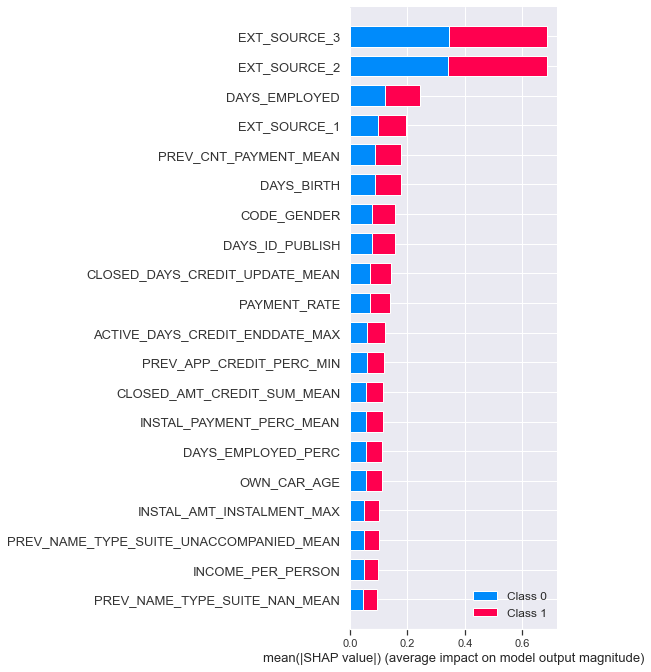

In [899]:
# Plot summary_plot
shap.summary_plot(shap_values, X_test)

In [900]:
info_cols = {
            'CODE_GENDER': "GENRE",
            'DAYS_BIRTH': "AGE",
            'NAME_FAMILY_STATUS': "STATUT FAMILIAL", 
            'CNT_CHILDREN': "NB ENFANTS",
            'FLAG_OWN_CAR': "PROPRIETAIRE VEHICULE",
            'FLAG_OWN_REALTY': "PROPRIETAIRE IMMOBILIER",
            'NAME_EDUCATION_TYPE': "NIVEAU EDUCATION",
            'OCCUPATION_TYPE': "OCCUPATION", 
            'DAYS_EMPLOYED': "NB ANNEES EMPLOI",
            'AMT_INCOME_TOTAL': "REVENUS",
            'AMT_CREDIT': "MONTANT CREDIT", 
            'NAME_CONTRACT_TYPE': "TYPE CONTRAT",
            'AMT_ANNUITY': "MONTANT ANNUITES",
            'NAME_INCOME_TYPE': "TYPE REVENUS",
            'EXT_SOURCE_1': "SCORE SOURCE 1",
            'EXT_SOURCE_2': "SCORE SOURCE 2",
            'EXT_SOURCE_3': "SCORE SOURCE 3",
            'INSTAL_DPD_MEAN' : "MOY DELAI PAIEMENT",
            'PAYMENT_RATE' : "TAUX PAIEMENT",
            'INSTAL_AMT_INSTALMENT_MEAN' : "DUREE MOYENNE CREDIT",
            'OWN_CAR_AGE' : "AGE VEHICULE",
            'APPROVED_CNT_PAYMENT_MEAN' : "MOYENS PAIEMENT",
            'ANNUITY_INCOME_PERC' : "% ANNUITE REVENU"
                }

In [901]:
X_train.rename(columns=info_cols, inplace=True)

 99%|===================| 24446/24597 [02:15<00:00]        

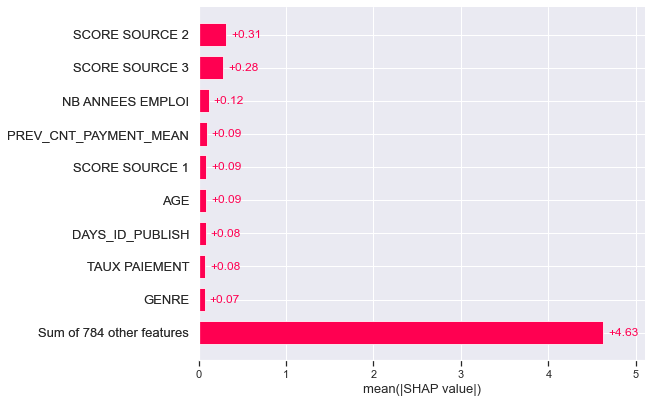

In [902]:
# compute SHAP values

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

# <a name="C11">Optmisation des gains</a>

In [903]:
score_gain = score_banque(tn, fp, fn, tp,2, 0, -30, 0)
score_gain

0.6782071097372488

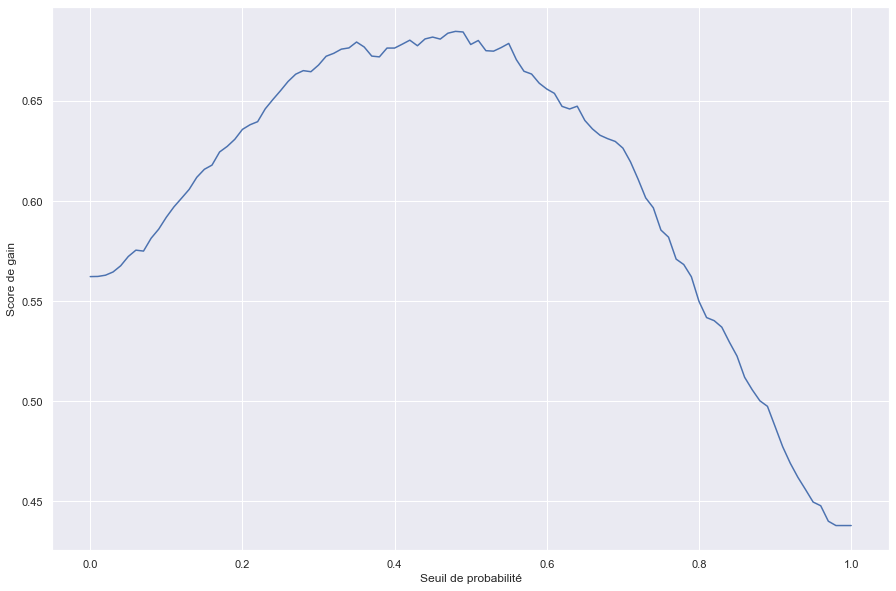

In [908]:
scor_int = []
int_seuil = np.arange(0.0, 1.01, 0.01)

for s in int_seuil:
    
  # Score du modèle : 0 à 1
  y_seuil=[]

  for i in probability_default_payment:
    if i >= s:
      y_seuil.append(1)
    elif i < s:
       y_seuil.append(0)

  tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()
  
  scor_int.append(score_banque(tn, fp, fn, tp, 2, 0, -30, 0))
    
# Affichage du gain en fonction du seuil de solvabilité    
plt.figure(figsize=(15, 10))
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Score de gain")
plt.show()

# Partie 3 : Dashboard

# <a name="C12">Déploiement du modèle</a>

In [905]:
#Sauvegarde du modèle
pickle.dump(best_model, open("best_model.pkl", "wb"))

In [906]:
#Sauvegarde du modèle
pickle.dump(score_gain, open("best_threshold.pkl", "wb"))

In [ ]:
#The end of the notebook